Distributed Services
====================

**NOTE:** This notebook and those that follow are to be run on the BBP Geneva cluster.

The cluster contains the following distributed frameworks:

*  **Spark**, running at `spark://schedulers:7077`
*  **Dask**, running at `schedulers:9000`

Each of these systems has a central controller/scheduler/master that manages worker processes on other computers on your cluster.  

This notebook contains setup information for connecting to each of these services.

Dask and spark also provide web interfaces with a variety of feedback

-  [Dask dashboard](../../../9002/status) 
-  [Spark UI](../../../9070)

In [ ]:
from dask.distributed import Client
client = Client('schedulers:9000')
client

Distributed Cross Validated Parameter Search
=============

In the previous section we parallelized cross-validated parameter search on a single machine.  In this notebook we do the same exercise, but now on a distributed cluster.  

### Requirements

This notebook should be run on the provided cluster.  View the README for connection information.

### Imports

In [1]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import ParameterSampler
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

### Shared Software Environment

`cv_params_demo` is a local .py file that defines the functions we are going to use.
In the local case, we imported functions from this module.
We will run into issues if our worker machines lack the `cv_params_demo.py` file.
Distributed computing frameworks have mechanisms to solve this by sending .py files around.
In order to skip dealing with this, we are going to include all of the content of that file in this notebook with the `%run` magic:

In [2]:
%run cv_params_demo.py

In [3]:
# Collect Data
digits = load_digits()  

# Construct parameter grid
param_grid = {
    'C': np.logspace(-10, 10, 1001),
    'gamma': np.logspace(-10, 10, 1001),
    'tol': np.logspace(-4, -1, 4),
}

## Exercise

We extend the concurrent.futures and Spark solutions to scale our computation across multiple machines.

In [4]:
cv_splits = [load_cv_split(i) for i in range(2)]  # Increase the number 2 after parallel computation acheived
param_samples = ParameterSampler(param_grid, 10)  # Increase the number 10 after parallel computation acheived

### Concurrent.futures solution

We've included the `concurrent.futures` solution from the previous notebook below.  You may want to replace the `ThreadPoolExecutor` below with a `dask.distributed.Client` object and point it to the Dask scheduler.

While it runs you may want to use [Dask's diagnostic dashboard](../../../9002/status) to get feedback from the cluster.  We recommend setting up the dashboard and your notebook side-by-side on your computer screen

In [5]:
# %load solutions/cvgs-1.py
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor()

futures = []

parameters = list(param_samples)

for split in cv_splits:
    for params in parameters:
        future = e.submit(evaluate_one, SVC, params, split)
        futures.append(future)

results = [f.result() for f in futures]


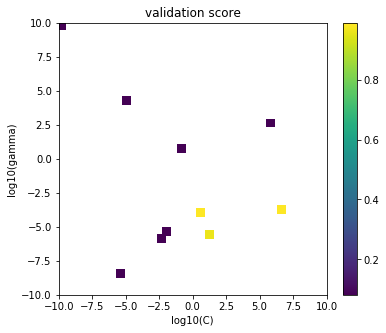

In [6]:
plot_results(results)

---
### Solution using Spark

Here we provide the local Spark solution to this problem as well.  Redirect your SparkContext to the Spark master.  While this runs you may want to use [Spark's diagnostic dashboard](../../../9070) to get feedback from the cluster.

In [ ]:
from pyspark import SparkContext
sc = SparkContext(...)
sc

In [ ]:
cv_rdd = sc.parallelize(cv_splits)
param_rdd = sc.parallelize(list(param_samples))

rdd = param_rdd.cartesian(cv_rdd)
results = rdd.map(lambda tup: evaluate_one(SVC, tup[0], tup[1]))

results = results.collect()

In [1]:
# If you need to terminate your spark context
# sc.stop()

In [ ]:
plot_results(results)

## Concluding thoughts

1.  Scaling computations can give you more precise insight into sampling problems
2.  The lessons you learned in the last section carry over from your laptop to cluster computing
3.  Visual diagnostic dashboards can help connect you to what is happening on your cluster